In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft, fftfreq
from scipy.io import loadmat
import xlsxwriter 
%matplotlib inline
import import_ipynb
import functions_NGD
import random

importing Jupyter notebook from functions_NGD.ipynb


## Load data / find cross-correlation of ganglion cell output

importing Jupyter notebook from NGDfunc.ipynb


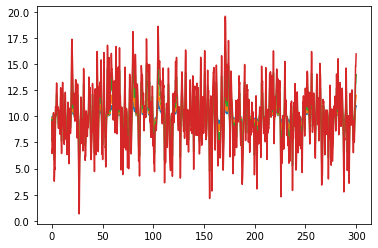

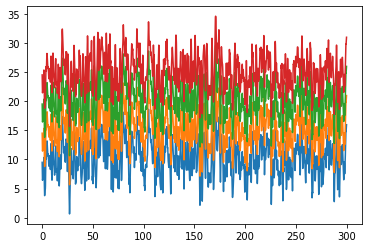

In [2]:
import os
os.chdir('F:/我的雲端硬碟/Retina exp/python code/functions')
import import_ipynb
import NGDfunc

dt=0.01
tau_ou=0.5
fc=1
T_ou=300
nsteps_ou=int(T_ou/dt)
randseed = np.random.normal(0, 50, nsteps_ou)
time_ou,x_ou=NGDfunc.OU(T_ou,tau_ou,'no',dt,randseed)
time_ou,x_lpou=NGDfunc.OU(T_ou,tau_ou,fc,dt,randseed)

amp=[0.5,1,2,3]
mean=10
x_set=[]
# x_set.append(x_lpou/np.std(x_lpou)*amp[3]+20)

for i in range(len(amp)):
    x_set.append(x_lpou/np.std(x_lpou)*amp[i]+mean)
    plt.plot(time_ou,x_set[i])
plt.show()

amp1=3
mean1=[10,15,20,25]
x1_set=[]
for i in range(len(mean1)):
    x1_set.append(x_lpou/np.std(x_lpou)*amp1+mean1[i])
    plt.plot(time_ou,x1_set[i])

## NGD output

In [3]:
alpha,beta,K,g=6,1.6,22,10 # channel 39
# alpha,beta,K,g=8,1.4,37,10 # channel 47
y_set=[functions_NGD.NGD(x_set[j],dt,alpha,beta,K,g,1)[0] for j in range(np.size(x_set,0))] 
z_set=[functions_NGD.NGD(x_set[j],dt,alpha,beta,K,g,1)[1] for j in range(np.size(x_set,0))] 

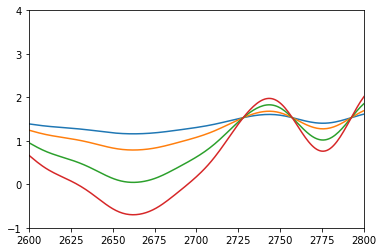

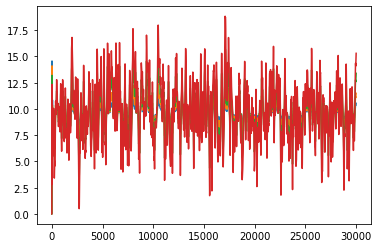

In [4]:
for i in range(4):
    plt.plot(y_set[i])
plt.ylim(-1,4)
plt.xlim(2600,2800)
plt.show()
for i in range(4):
    plt.plot(z_set[i])
# plt.ylim(-1,4)
# plt.xlim(2000,4000)

## Adding horizontal feedback to NGD output (y+z)

### MI and cross correlation of B

[0.8 0.9]


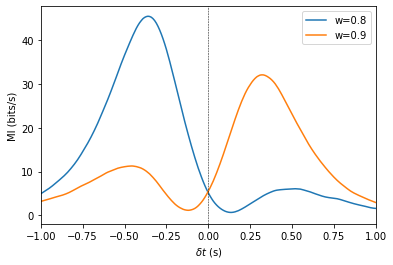

In [5]:
# wy=np.linspace(0.8,1,5)
wy=np.array([0.8,0.9])
# wy=0.9
print(wy)
# wy=[]
iamp=3
x=x_set[iamp]
y=y_set[iamp]
z=z_set[iamp]
B=[wy[k]*y-(1-wy[k])*z for k in range(len(wy))]
MIxyz=[[] for i in range(len(B))]
corrxyz=[[] for i in range(len(B))]
for k in range(len(B)):
    tsxyz,MIxyz[k]=functions_NGD.MI(functions_NGD.EqualState(x,8),functions_NGD.EqualState(B[k],8),dt,[-2,2])
    tc,corrxyz[k]=functions_NGD.xcorr_quick(x,B[k],5,0.01)
# color2=['k','r']
for i in range(len(B)):
    plt.plot(tsxyz,MIxyz[i],label='w='+str(round(wy[i],3)))
plt.legend()
plt.xlim(-1,1)
plt.ylabel('MI (bits/s)')
plt.xlabel('$\delta t$ (s)')
plt.axvline(x=0,c='k',linewidth=0.5,linestyle='dashed')
# plt.grid()
# find prediction horizon

# for i in range(len(MIxyz)):
#     plt.plot(tsxyz[np.argmax(MIxyz[i])],max(MIxyz[i]),'o')
# plt.show()

# plt.savefig('F:/我的雲端硬碟/Retina exp/Poster present/Sfn poster 20210111/figure/MI_fb_ff.png',dpi=300)

# for i in range(len(B)):
#     plt.plot(tc,corrxyz[i])
# plt.xlim(-5,5)
# plt.grid()

### generate poisson spikes

In [6]:
# poisson as a function
# ON cell: onoff=0
# OFF cell: onoff=1
def poisson(r_in,thr,onoff):
    rtemp=(-1)**onoff*(r_in-thr)
    rtemp[rtemp<0]=0
    rtemp=rtemp/(np.sum(rtemp[100:]))*10*len(rtemp[100:]) # set the mean firing rate as 5 hz
    tempspikes=np.zeros(len(rtemp))
    for step in range(len(rtemp)):
        if random.random()<rtemp[step]*dt:
            tempspikes[step]=1
        else:
            tempspikes[step]=0
    return tempspikes

In [7]:
a=np.array([1,2,3])
a[0:-1]

array([1, 2])

In [8]:
thr=0.6
SpikeTrains_Poisson=[[] for i in range(len(B))]
for i in range(len(B)):
    rtemp=B[i]-thr
    rtemp[rtemp>0]=0
    rtemp=rtemp/np.mean(rtemp)*5 # let the mean firing rate as 5 hz
    tempspikes=np.zeros(len(rtemp))
    for step in range(len(rtemp)):
        if random.random()<rtemp[step]*dt:
            tempspikes[step]=1
        else:
            tempspikes[step]=0
    SpikeTrains_Poisson[i]=tempspikes

(5000, 6000)

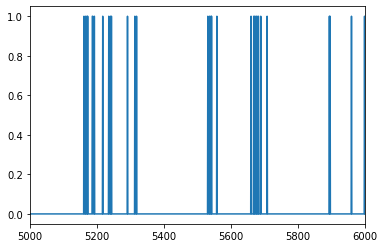

In [9]:
plt.plot(SpikeTrains_Poisson[1])
plt.xlim(5000,6000)

In [10]:
print(np.size(SpikeTrains_Poisson,0))

2


### calculate STA

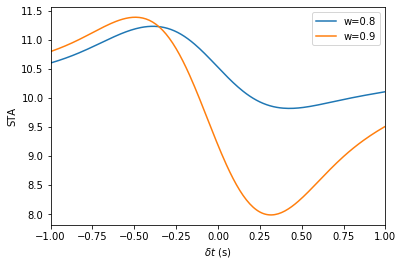

In [11]:
STAwindow=5
PoissonSTA_set=[[] for i in range(np.size(SpikeTrains_Poisson,0))]
for ii in range(np.size(SpikeTrains_Poisson,0)):
    sss=np.zeros(int(1+STAwindow/dt*2))
    n_spikes=0
    for i in range(len(SpikeTrains_Poisson[ii])):
        if SpikeTrains_Poisson[ii][i]>0:
            if (i-int(STAwindow/dt)>0) & (i+int(STAwindow/dt)<len(SpikeTrains_Poisson[ii])-1):
                n_spikes+=SpikeTrains_Poisson[ii][i]
                sss+=SpikeTrains_Poisson[ii][i]*x[i-int(STAwindow/dt):i+int(STAwindow/dt)+1]
    PoissonSTA_set[ii]=sss/n_spikes
t2s=np.arange(-5,5+1e-5,dt)

for j in range(np.size(SpikeTrains_Poisson,0)):
    plt.plot(t2s,PoissonSTA_set[j],label='w='+str(round(wy[j],3)))
plt.ylabel('STA')
plt.xlabel('$\delta t$ (s)')
plt.legend()
plt.xlim(-1,1)
plt.show()

## NGD Adding gain control

### feedback loop from y output to x input

In [12]:
def NGD_FBFF_GainControl(xin,h=0,psi=0.1):
    alpha,beta,gamma,K,g=6,1.6,1,22,10
    y=np.zeros(len(xin))
    z=np.zeros(len(xin))
    v=np.zeros(len(xin))
    GC=np.zeros(len(xin))
    for i in range(len(xin)-1):
        dy=dt*(-alpha*y[i]+K*(GC[i]*xin[i]-z[i]))
        dz=dt*(-beta*z[i]+g*y[i])
        dv=dt*(-gamma*v[i]+h*y[i])
        y[i+1]=y[i]+dy
        z[i+1]=z[i]+dz
        v[i+1]=v[i]+dv
        GC[i+1]=1/(1+v[i+1]**4)
    B=(1-psi)*y-psi*z
    return y,z,v,GC,B

(3000, 6000)

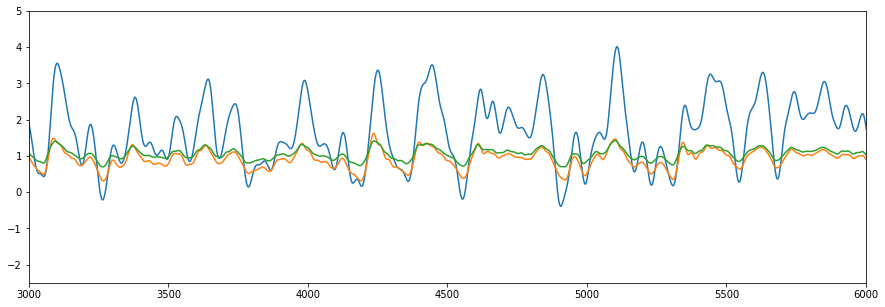

In [13]:
y_h0,z_h0,v_h0,GC_h0,B_h0=NGD_FBFF_GainControl(x)
y_h1,z_h1,v_h1,GC_h1,B_h1=NGD_FBFF_GainControl(x,1,0.13)
y_1,z_1,v_1,GC_1,B_1=NGD_FBFF_GainControl(x1_set[1],1,0.13)

f1,ax1=plt.subplots(figsize=(15,5))
plt.plot(y_h0)
plt.plot(y_h1)
plt.plot(y_1)
plt.ylim(-2.5,5)
plt.xlim(3000,6000)

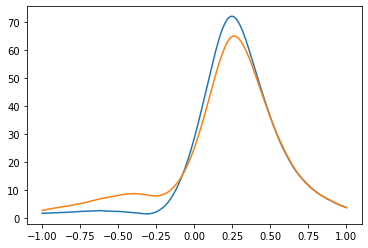

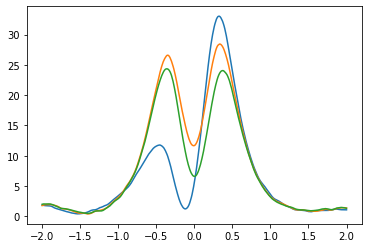

In [14]:
from NGDfunc import EqualState
from NGDfunc import MI

tl,MI_yh0=MI(EqualState(x,8),EqualState(y_h0,8),dt,[-1,1])
tl,MI_yh1=MI(EqualState(x,8),EqualState(y_h1,8),dt,[-1,1])

plt.plot(tl,MI_yh0)
plt.plot(tl,MI_yh1)
plt.show()

tl,MI_Bh0=MI(EqualState(x,8),EqualState(B_h0,8),dt,[-2,2])
tl,MI_Bh1=MI(EqualState(x,8),EqualState(B_h1,8),dt,[-2,2])
tl,MI_Bnew=MI(EqualState(x,8),EqualState(B_1,8),dt,[-2,2])

plt.plot(tl,MI_Bh0)
plt.plot(tl,MI_Bh1)
plt.plot(tl,MI_Bnew)

(2000, 5000)

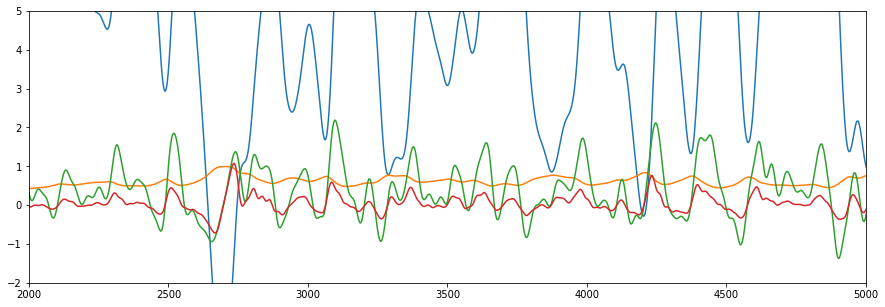

In [15]:
ff,axx=plt.subplots(figsize=(15,5))
plt.plot(x-5)
plt.plot(GC_h1)
plt.plot(B_h0)
plt.plot(B_h1)
plt.ylim(-2,5)
plt.xlim(2000,5000)

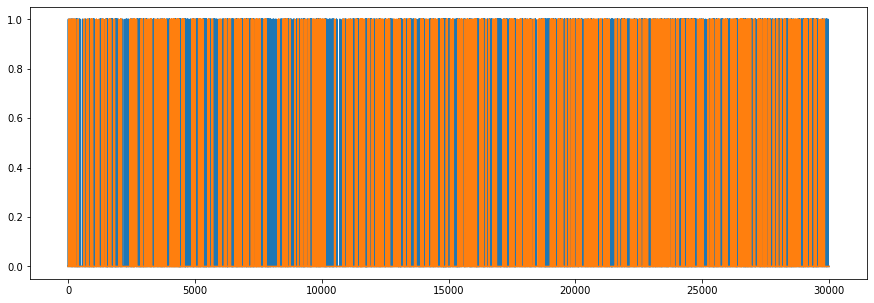

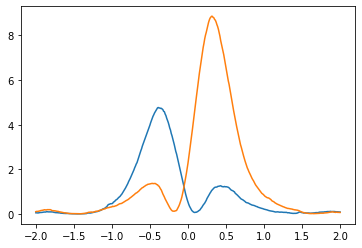

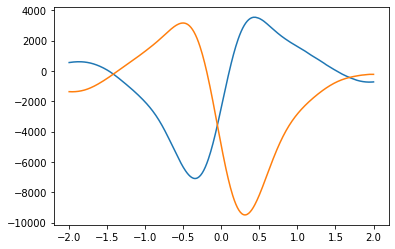

In [16]:
spikes_h1_on=poisson(B_h1,0,0)
spikes_h1_off=poisson(B_h1,0,1)
plt.subplots(figsize=(15,5))
plt.plot(spikes_h1_on)
plt.plot(spikes_h1_off)

tl,MIspikes_h1_on=MI(EqualState(x,8),spikes_h1_on,dt,[-2,2])
tl,MIspikes_h1_off=MI(EqualState(x,8),spikes_h1_off,dt,[-2,2])
plt.subplots(figsize=(6,4))
plt.plot(tl,MIspikes_h1_on)
plt.plot(tl,MIspikes_h1_off)

from NGDfunc import xcorr_quick
xx=x-np.mean(x)
tl,corr_on=xcorr_quick(xx,spikes_h1_on,[-2,2],dt)
tl,corr_off=xcorr_quick(xx,spikes_h1_off,[-2,2],dt)
plt.subplots(figsize=(6,4))
plt.plot(tl,corr_on)
plt.plot(tl,corr_off)

### inputs with different contrast

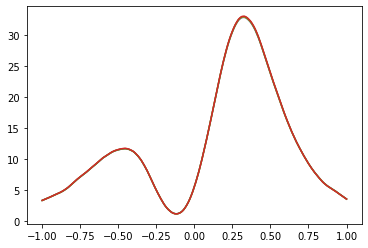

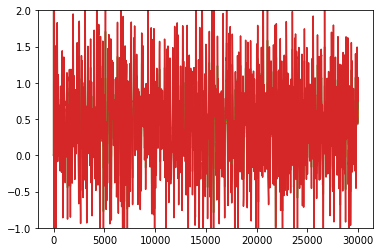

In [17]:
f1,ax1=plt.subplots()
f2,ax2=plt.subplots()
B_cst=[0 for k in range(len(x_set))]
for ii in range(len(x_set)):
    x=x_set[ii]
    y_cst,z_cst,v_cst,GC_cst,B_cst[ii]=NGD_FBFF_GainControl(x,0,0.1)
    tl,MI_cst=MI(EqualState(x,8),EqualState(B_cst[ii],8),dt,[-1,1])
    ax1.plot(tl,MI_cst)
    ax2.plot(B_cst[ii])
    ax2.set_ylim(-1,2)
#     ax2.set_xlim(5400,5800)

#### generate spieks

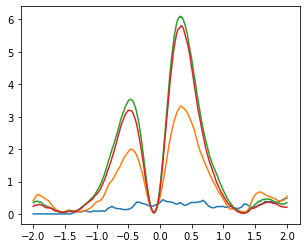

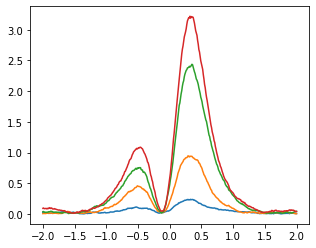

In [18]:
spikes_cst_on=[0 for i in range(len(B_cst))]
spikes_cst_off=[0 for i in range(len(B_cst))]
fon,axon=plt.subplots(figsize=(5,4))
foff,axoff=plt.subplots(figsize=(5,4))
for i in range(len(B_cst)):
    spikes_cst_on[i]=poisson(B_cst[i],0.8,0)
    spikes_cst_off[i]=poisson(B_cst[i],0.8,1)
    tl,MI_cst_spikes_on=MI(EqualState(x,8),spikes_cst_on[i],dt,[-2,2])
    tl,MI_cst_spikes_off=MI(EqualState(x,8),spikes_cst_off[i],dt,[-2,2])
    axon.plot(tl,MI_cst_spikes_on)
    axoff.plot(tl,MI_cst_spikes_off)

In [19]:
sum(spikes_cst_on[3])

3013.0

### gain control at two outputs

In [20]:
def NGD_FBFF_GainControl_4(xin,h=0,f=0,psi=0.1):
    alpha,beta,gamma,kappa,K,g=6,1.6,1,0.6,22,10
    y=np.zeros(len(xin))
    z=np.zeros(len(xin))
    v=np.zeros(len(xin))
    w=np.zeros(len(xin))
    GC1=np.zeros(len(xin))
    GC2=np.zeros(len(xin))
    B=np.zeros(len(xin))
    for i in range(len(xin)-1):
        dy=dt*(-alpha*y[i]+K*(xin[i]-z[i]))
        dz=dt*(-beta*z[i]+g*y[i])
        dv=dt*(-gamma*v[i]+h*y[i])
        dw=dt*(-kappa*w[i]+f*z[i])
        y[i+1]=y[i]+dy
        z[i+1]=z[i]+dz
        v[i+1]=v[i]+dv
        w[i+1]=w[i]+dw
        if v[i+1]>0:GC1[i+1]=1/(1+v[i+1]**4)
        else:GC1[i+1]=1
        if w[i+1]>0:GC2[i+1]=1/(1+w[i+1]**4)
        else:GC2[i+1]=1
    y_gc=y*GC1
    z_gc=z*GC2
    B=(1-psi)*y_gc-psi*z_gc
    return y_gc,z_gc,GC1,GC2,B

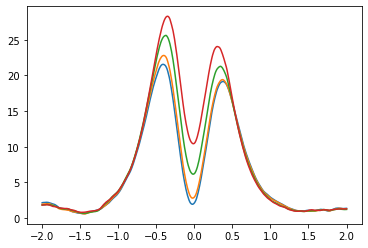

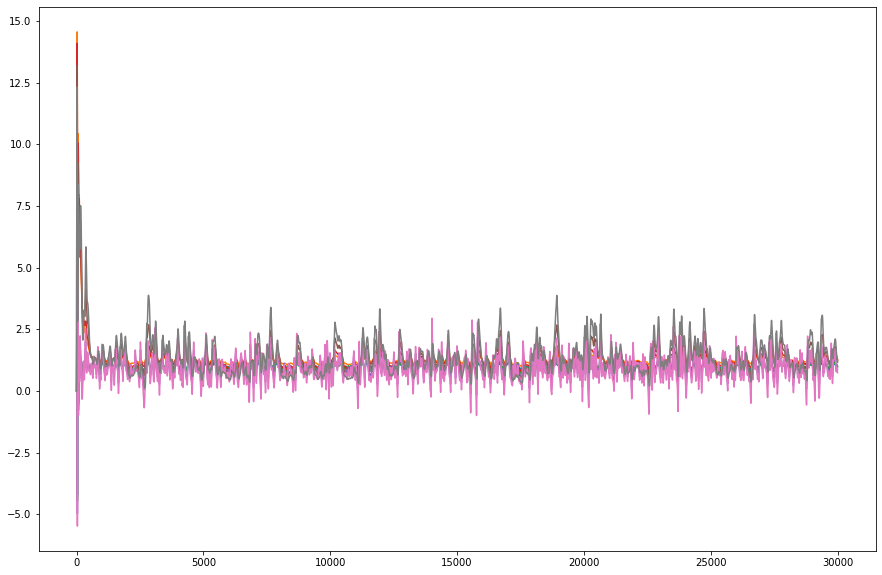

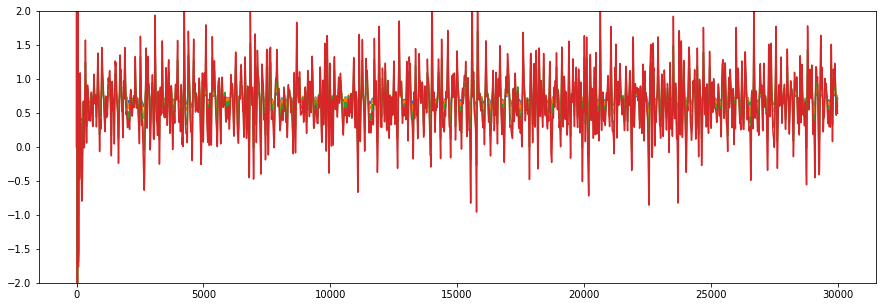

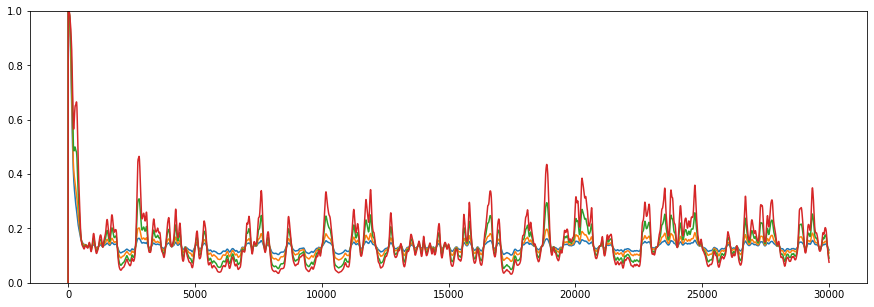

In [21]:
f1,ax1=plt.subplots()
f2,ax2=plt.subplots(figsize=(15,10))
f3,ax3=plt.subplots(figsize=(15,5))
f4,ax4=plt.subplots(figsize=(15,5))
B_outgain=[0 for kk in range(len(x_set))]
for i in range(len(x_set)):
    x_outgain=x_set[i]
    y_outgain,z_outgain,GC1_outgain,GC2_outgain,B_outgain[i]=NGD_FBFF_GainControl_4(x_outgain,0.55,0.1,0.13) #,0.55,0.1,0.13
    tl,MI_outgain=MI(EqualState(x_outgain,8),EqualState(B_outgain[i],8),dt,[-2,2])
    ax1.plot(tl,MI_outgain)
    ax2.plot(y_outgain)
    ax2.plot(z_outgain)
#     ax2.set_xlim(1000,1500)
    ax2.plot()
    ax3.plot(B_outgain[i])
    ax3.set_ylim(-2,2)
    
    ax4.plot(GC2_outgain)
    ax4.set_ylim(0,1)

Gain plotting

(-1499.9, 31497.9)

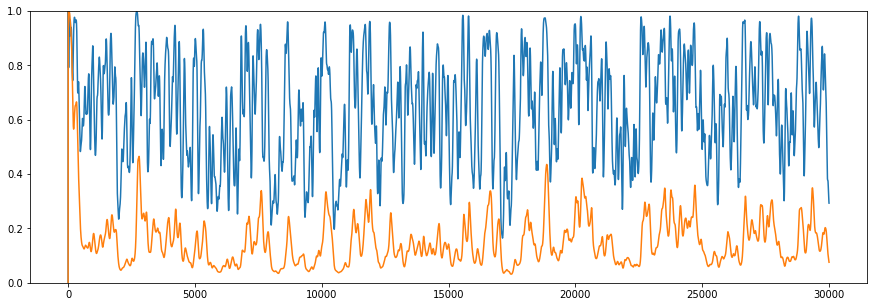

In [22]:
plt.subplots(figsize=(15,5))
# plt.plot(y_outgain)
# plt.plot(y_outgain/GC1_outgain)
plt.plot(GC1_outgain)
plt.plot(GC2_outgain)
plt.ylim(0,1)
plt.xlim()

In [23]:
np.mean(B_outgain[i])

0.6367076623794996

generate ON and OFF spike trains

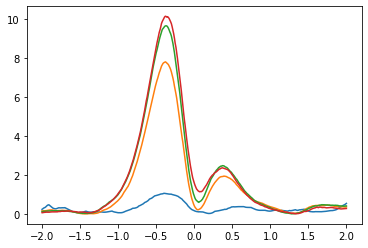

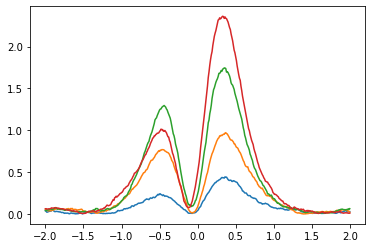

In [28]:
spikes_outgain_on=[0 for i in range(len(B_outgain))]
spikes_outgain_off=[0 for i in range(len(B_outgain))]
f_onspike,ax_onspike=plt.subplots()
f_offspike,ax_offspike=plt.subplots()
threshold=0.9
for i in range(len(B_outgain)):
    spikes_outgain_on=poisson(B_outgain[i],threshold,0)
    spikes_outgain_off=poisson(B_outgain[i],threshold,1)
    tl,MI_outgain_onspike=MI(EqualState(x_outgain,8),spikes_outgain_on,dt,[-1,1])
    tl,MI_outgain_offspike=MI(EqualState(x_outgain,8),spikes_outgain_off,dt,[-1,1])
    ax_onspike.plot(tl,MI_outgain_onspike)
    ax_offspike.plot(tl,MI_outgain_offspike)

(16000, 16250)

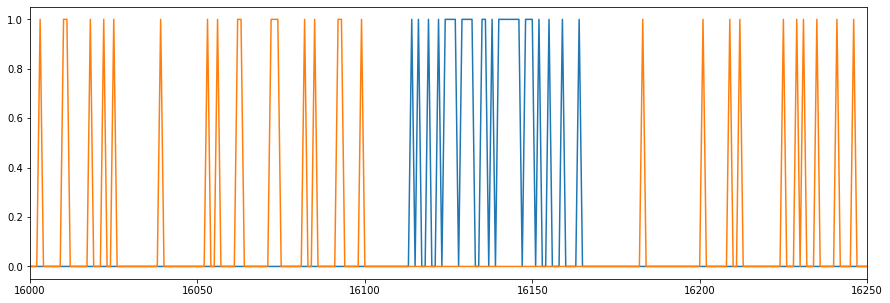

In [25]:
plt.subplots(figsize=(15,5))
plt.plot(spikes_outgain_on)
plt.plot(spikes_outgain_off)
sum(spikes_outgain_off)
plt.xlim(16000,16250)

#### White noise stimuli

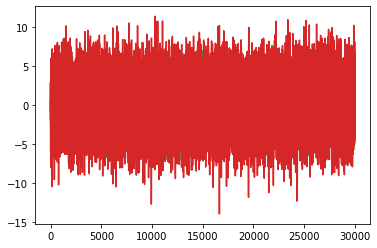

In [26]:
dt=0.01
T_ou=300
amp_white=[0.5,1,2,3]
x_white=[0 for i in range(len(amp_white))]
for j in range(len(amp_white)):
    x_white[j]=np.random.normal(0, amp_white[j], nsteps_ou)
    plt.plot(x_white[j])

(-1.05, 0.05)

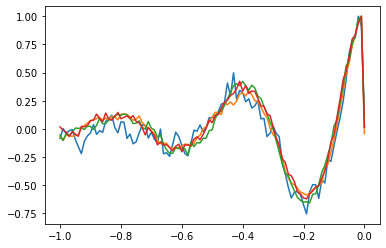

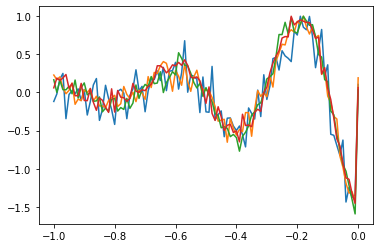

In [27]:
# white noise STA
from NGDfunc import xcorr_quick
B_white=[0 for i in range(len(amp_white))]
for k in range(len(amp_white)):
    y_white,z_white,GC1_white,GC2_white,B_white[k]=NGD_FBFF_GainControl_4(x_white[k],0.55,0.1,0.13)
# spikes_white_on=[0 for i in range(len(B_white))]
# spikes_white_off=[0 for i in range(len(B_white))]
f_1,ax_1=plt.subplots()
f_2,ax_2=plt.subplots()
threshold=0.8
for i in range(len(B_outgain)):
    spikes_white_on=poisson(B_white[i],threshold,0)
    spikes_white_off=poisson(B_white[i],threshold,1)
    tlcorr,corr_white_onspike=xcorr_quick(x_white[i],spikes_white_on,[-1,0],dt)
    tlcorr,corr_white_offspike=xcorr_quick(x_white[i],spikes_white_off,[-1,0],dt)
    ax_1.plot(tlcorr,corr_white_onspike/max(corr_white_onspike))
    ax_2.plot(tlcorr,corr_white_offspike/max(corr_white_offspike))
ax_1.set_xlim()
ax_2.set_xlim()

## CCDM

c:\python37\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
c:\python37\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


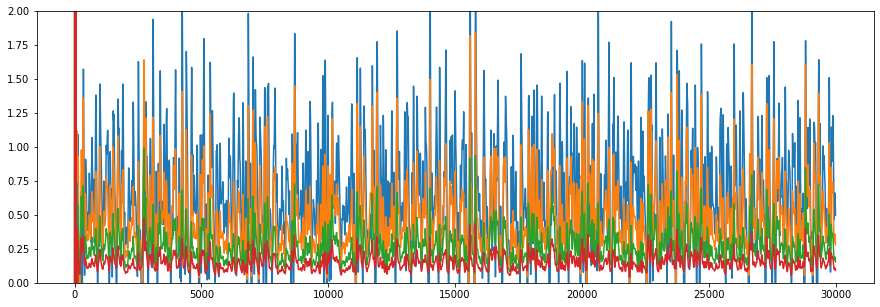

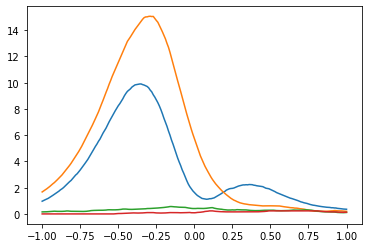

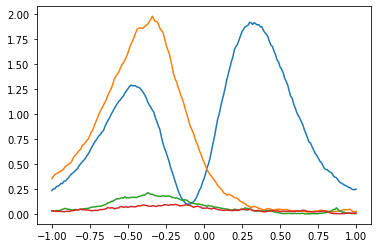

In [34]:
f_ccdm_B,ax_ccdm_B=plt.subplots(figsize=(15,5))
B_ccdm=[0 for i in range(len(x_set))]
for i in range(len(x_set)):
    x_ccdm=x1_set[i]
    y_ccdm,z_ccdm,GC1_ccdm,GC2_ccdm,B_ccdm[i]=\
                            NGD_FBFF_GainControl_4(x_ccdm,0.55,0.1,0.13)
    ax_ccdm_B.plot(B_ccdm[i])
ax_ccdm_B.set_ylim(0,2)
    
threshold=0.9
f_ccdm_on,ax_ccdm_on=plt.subplots()
f_ccdm_off,ax_ccdm_off=plt.subplots()
for i in range(len(B_ccdm)):
    spikes_ccdm_on=poisson(B_ccdm[i],threshold,0)
    spikes_ccdm_off=poisson(B_ccdm[i],threshold,1)
    tl,MI_ccdm_onspike=MI(EqualState(x_ccdm,8),spikes_ccdm_on,dt,[-1,1])
    tl,MI_ccdm_offspike=MI(EqualState(x_ccdm,8),spikes_ccdm_off,dt,[-1,1])
    ax_ccdm_on.plot(tl,MI_ccdm_onspike)
    ax_ccdm_off.plot(tl,MI_ccdm_offspike)    